<a href="https://colab.research.google.com/github/Abiola0101/Toronto-Crime-Predictor/blob/main/Project_Toronto_Crime_Predictor_Leveraging_Data_for_Public_Safety.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Details**

This project focuses on analyzing and predicting crime in Toronto using machine learning. The problem is that law enforcement and city planners lack accurate, real-time tools to anticipate crime patterns. We developed a predictive model trained on historical crime data to forecast potential incidents based on time, location, and other contextual features. The solution is deployed as a Flask API accessible via a public URL for easy integration. The purpose is to support proactive policing, resource allocation, and public safety planning through data-driven insights.

**Exploratory Data Analysis (EDA)**

(420200, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420200 entries, 0 to 420199
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   _id                420200 non-null  int64  
 1   EVENT_UNIQUE_ID    420200 non-null  object 
 2   REPORT_DATE        420200 non-null  object 
 3   OCC_DATE           420200 non-null  object 
 4   REPORT_YEAR        420200 non-null  int64  
 5   REPORT_MONTH       420200 non-null  object 
 6   REPORT_DAY         420200 non-null  int64  
 7   REPORT_DOY         420200 non-null  int64  
 8   REPORT_DOW         420200 non-null  object 
 9   REPORT_HOUR        420200 non-null  int64  
 10  OCC_YEAR           420056 non-null  float64
 11  OCC_MONTH          420056 non-null  object 
 12  OCC_DAY            420056 non-null  float64
 13  OCC_DOY            420056 non-null  float64
 14  OCC_DOW            420056 non-null  object 
 15  OCC_HOUR           420200 non-null  in

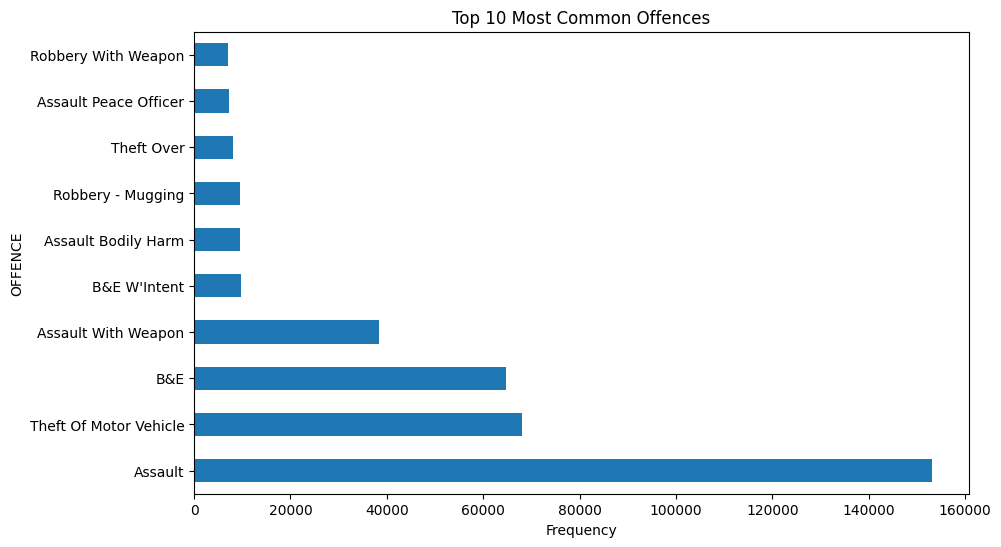

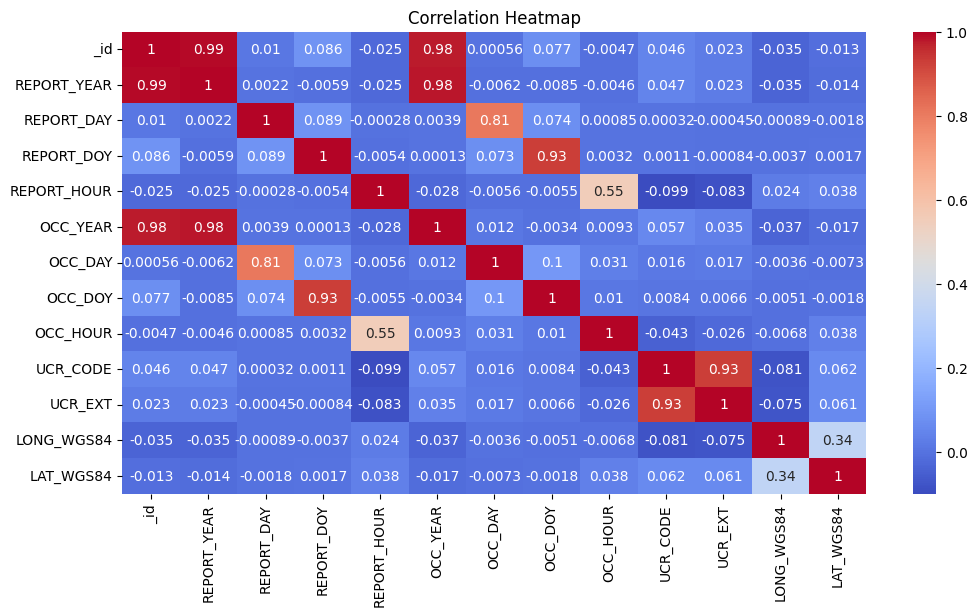

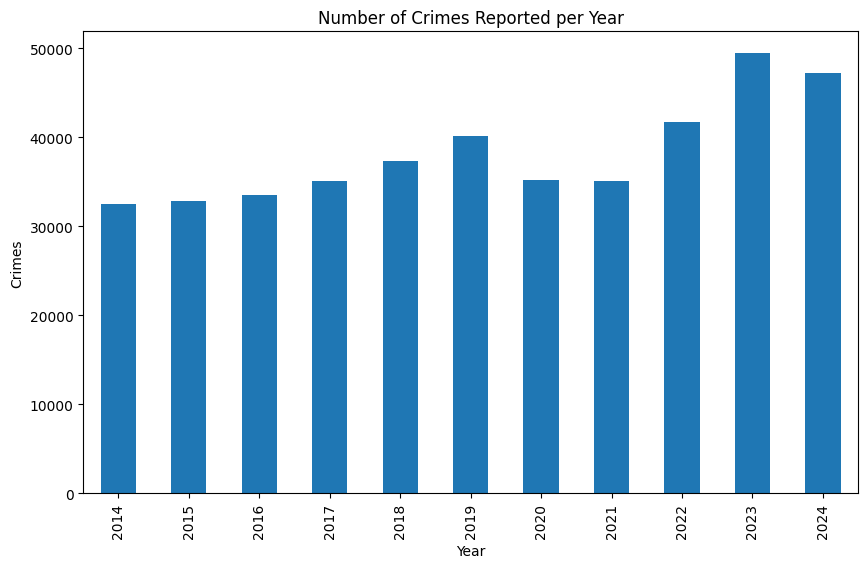

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
# Use the 'error_bad_lines=False' argument to skip problematic lines
df = pd.read_csv("major-crime-indicators.csv", on_bad_lines='skip')

# Basic info and preview
print(df.shape)
print(df.info())
print(df.describe())
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Check for duplicates
print("Duplicates:", df.duplicated().sum())

# Visualize top offences
plt.figure(figsize=(10,6))
df['OFFENCE'].value_counts().head(10).plot(kind='barh')
plt.title("Top 10 Most Common Offences")
plt.xlabel("Frequency")
plt.show()

# Heatmap of correlations (only numeric columns)
plt.figure(figsize=(12,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Convert 'REPORT_YEAR' to numeric, handling errors
df['REPORT_YEAR'] = pd.to_numeric(df['REPORT_YEAR'], errors='coerce')

# Crimes over years
plt.figure(figsize=(10,6))
df['REPORT_YEAR'].value_counts().sort_index().plot(kind='bar')
plt.title("Number of Crimes Reported per Year")
plt.xlabel("Year")
plt.ylabel("Crimes")
plt.show()

**Data Preprocessing and Feature Engineering**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Step 1: Load the data (use the correct file path)
# file_path = 'path_to_your_file.csv'  # Replace with the actual file path - This line is commented out
# and the next line is changed to use 'major-crime-indicators.csv'
df = pd.read_csv('major-crime-indicators.csv', on_bad_lines='skip') # Load the original DataFrame
try:
    # df = pd.read_csv(file_path)  # Attempt to load the data - commented out as it's not needed
    print("Data shape after loading:", df.shape)
    print("Data preview after loading:")
    print(df.head())  # Check the first few rows to ensure the data is loaded
except Exception as e:
    print(f"Error loading data: {e}")
    df = pd.DataFrame()  # If error, create an empty DataFrame

# Step 2: Check for missing columns
required_columns = ['REPORT_YEAR', 'REPORT_MONTH', 'REPORT_DAY', 'OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'REPORT_HOUR']
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print("Missing columns:", missing_columns)
else:
    print("All required columns are present.")

# Step 3: Drop columns if they exist
existing_columns = df.columns
columns_to_drop = ['_id', 'EVENT_UNIQUE_ID', 'NEIGHBOURHOOD_158', 'NEIGHBOURHOOD_140']
columns_to_drop = [col for col in columns_to_drop if col in existing_columns]
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Step 4: Handle missing values
# Check the missing data percentage per column
missing_data_percentage = df.isnull().mean() * 100
print("Missing data percentage per column:")
print(missing_data_percentage)

# If there are missing rows (e.g., due to NaNs), decide how to handle:
if df.isnull().sum().sum() > 0:
    print("Dropping rows with missing data...")
    df.dropna(inplace=True)

print("Data shape after dropna:", df.shape)

# Step 5: Feature Engineering
# Create datetime columns from year, month, day
df['REPORT_DATE'] = pd.to_datetime(df['REPORT_YEAR'].astype(str) + '-' + df['REPORT_MONTH'].astype(str) + '-' + df['REPORT_DAY'].astype(str), errors='coerce')
df['OCC_DATE'] = pd.to_datetime(df['OCC_YEAR'].astype(str) + '-' + df['OCC_MONTH'].astype(str) + '-' + df['OCC_DAY'].astype(str), errors='coerce')


# Weekend indicator
df['IS_WEEKEND'] = df['REPORT_DOW'].isin([5, 6]).astype(int)

# Convert REPORT_HOUR to numeric (force errors to NaN if conversion fails)
df['REPORT_HOUR'] = pd.to_numeric(df['REPORT_HOUR'], errors='coerce')

# Apply lambda for night shift
df['IS_NIGHT'] = df['REPORT_HOUR'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

# Season indicator
def map_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

df['SEASON'] = df['REPORT_MONTH'].apply(map_season)

# Label encode categorical columns
categorical_cols = ['DIVISION', 'LOCATION_TYPE', 'PREMISES_TYPE', 'OFFENCE', 'MCI_CATEGORY', 'SEASON', 'HOOD_158']
label_encoders = {}
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Feature Engineering: Crime volume per neighbourhood
crime_count = df['HOOD_158'].value_counts().to_dict()
df['LOCATION_RISK_SCORE'] = df['HOOD_158'].map(crime_count)

# Step 6: Check for missing values in numerical columns
numerical_cols = ['REPORT_HOUR', 'OCC_HOUR', 'REPORT_DAY', 'OCC_DAY', 'LONG_WGS84', 'LAT_WGS84', 'LOCATION_RISK_SCORE']
print(df[numerical_cols].isnull().sum())  # Check missing values in numerical columns

# Step 7: Impute missing values in numerical columns
numerical_cols = ['REPORT_HOUR', 'OCC_HOUR', 'REPORT_DAY', 'OCC_DAY', 'LONG_WGS84', 'LAT_WGS84', 'LOCATION_RISK_SCORE']

for col in numerical_cols:
    # Convert the column to numeric, handling errors by coercing to NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # Now impute with the mean
    df[col] = df[col].fillna(df[col].mean())


# Step 8: Normalize numerical columns
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Step 9: Define features and target
X = df.drop(columns=['MCI_CATEGORY'])  # or another target like 'OFFENCE'
y = df['MCI_CATEGORY']  # Predicting 'MCI_CATEGORY'

# Step 10: Confirm shape of data
print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Data shape after loading: (420200, 29)
Data preview after loading:
   _id EVENT_UNIQUE_ID REPORT_DATE    OCC_DATE  REPORT_YEAR REPORT_MONTH  \
0    1  GO-20141263217  2014-01-01  2013-12-31         2014      January   
1    2  GO-20141260715  2014-01-01  2014-01-01         2014      January   
2    3  GO-20141260730  2014-01-01  2014-01-01         2014      January   
3    4  GO-20141260597  2014-01-01  2014-01-01         2014      January   
4    5  GO-20141259762  2014-01-01  2013-12-31         2014      January   

   REPORT_DAY  REPORT_DOY  REPORT_DOW  REPORT_HOUR  ...  UCR_CODE UCR_EXT  \
0           1           1  Wednesday            16  ...      2135     210   
1           1           1  Wednesday             3  ...      1430     100   
2           1           1  Wednesday             3  ...      1430     100   
3           1           1  Wednesday             2  ...      1430     100   
4           1           1  Wednesday             2  ...      1430     100   

             

<ipython-input-2-17a8268a746a>:49: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['OCC_DATE'] = pd.to_datetime(df['OCC_YEAR'].astype(str) + '-' + df['OCC_MONTH'].astype(str) + '-' + df['OCC_DAY'].astype(str), errors='coerce')


REPORT_HOUR            0
OCC_HOUR               0
REPORT_DAY             0
OCC_DAY                0
LONG_WGS84             0
LAT_WGS84              0
LOCATION_RISK_SCORE    0
dtype: int64
Feature shape: (413774, 28)
Target shape: (413774,)


**Train a Machine Learning Model**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report # Import accuracy_score and classification_report


# Convert categorical columns to numeric
df['REPORT_YEAR'] = pd.to_numeric(df['REPORT_YEAR'], errors='coerce')
df['REPORT_MONTH'] = pd.to_numeric(df['REPORT_MONTH'], errors='coerce')
df['REPORT_DOY'] = pd.to_numeric(df['REPORT_DOY'], errors='coerce')
df['REPORT_DOW'] = pd.to_numeric(df['REPORT_DOW'], errors='coerce')
df['OCC_YEAR'] = pd.to_numeric(df['OCC_YEAR'], errors='coerce')
df['OCC_MONTH'] = pd.to_numeric(df['OCC_MONTH'], errors='coerce')
df['OCC_DOY'] = pd.to_numeric(df['OCC_DOY'], errors='coerce')
df['OCC_DOW'] = pd.to_numeric(df['OCC_DOW'], errors='coerce')

# Check the data types again
print(df.dtypes)

# Now we can safely drop or encode any non-numeric columns
X = df.drop(columns=['REPORT_DATE', 'OCC_DATE', 'UCR_CODE', 'UCR_EXT', 'HOOD_140'])  # Remove non-numeric columns

# If needed, encode categorical variables like 'SEASON' or 'DIVISION' using LabelEncoder or OneHotEncoder
# For example, let's apply LabelEncoder to 'SEASON' (assuming it's a categorical column)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X['SEASON'] = le.fit_transform(X['SEASON'])

# Ensure that the target variable 'y' is also numeric (if not already)
# If 'y' is categorical (e.g., MCI_CATEGORY), you may need to encode it
y = pd.to_numeric(y, errors='coerce')

# Now proceed with splitting and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

REPORT_DATE            datetime64[ns]
OCC_DATE               datetime64[ns]
REPORT_YEAR                     int64
REPORT_MONTH                  float64
REPORT_DAY                    float64
REPORT_DOY                      int64
REPORT_DOW                    float64
REPORT_HOUR                   float64
OCC_YEAR                      float64
OCC_MONTH                     float64
OCC_DAY                       float64
OCC_DOY                       float64
OCC_DOW                       float64
OCC_HOUR                      float64
DIVISION                        int64
LOCATION_TYPE                   int64
PREMISES_TYPE                   int64
UCR_CODE                        int64
UCR_EXT                         int64
OFFENCE                         int64
MCI_CATEGORY                    int64
HOOD_158                        int64
HOOD_140                       object
LONG_WGS84                    float64
LAT_WGS84                     float64
IS_WEEKEND                      int64
IS_NIGHT    

**Refine the Model using Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_model = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_model.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Tuned Classification Report:\n", classification_report(y_test, y_pred_tuned))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Tuned Model Accuracy: 1.0
Tuned Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43950
           1       1.00      1.00      1.00     13454
           2       1.00      1.00      1.00     15320
           3       1.00      1.00      1.00      7270
           4       1.00      1.00      1.00      2761

    accuracy                           1.00     82755
   macro avg       1.00      1.00      1.00     82755
weighted avg       1.00      1.00      1.00     82755



**Model Explainability (SHAP & LIME)**

In [ ]:
pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ae3e6a354c871682fe14026921fc90e5bb2de2075b89d84b52d2b5ffc243ef31
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
print("X_sample type:", type(X_sample))
print("X_sample shape:", X_sample.shape)
print("shap_values type:", type(shap_values))
print("len(shap_values):", len(shap_values))  # Should be 2 if binary classification
print("shap_values[1] shape:", np.array(shap_values[1]).shape)
print("shap_values[0] shape:", np.array(shap_values[0]).shape)


X_sample type: <class 'pandas.core.frame.DataFrame'>
X_sample shape: (100, 24)
shap_values type: <class 'numpy.ndarray'>
len(shap_values): 100
shap_values[1] shape: (24, 5)
shap_values[0] shape: (24, 5)


shap_values.values.shape: (100, 24, 5)
X_sample.shape: (100, 24)


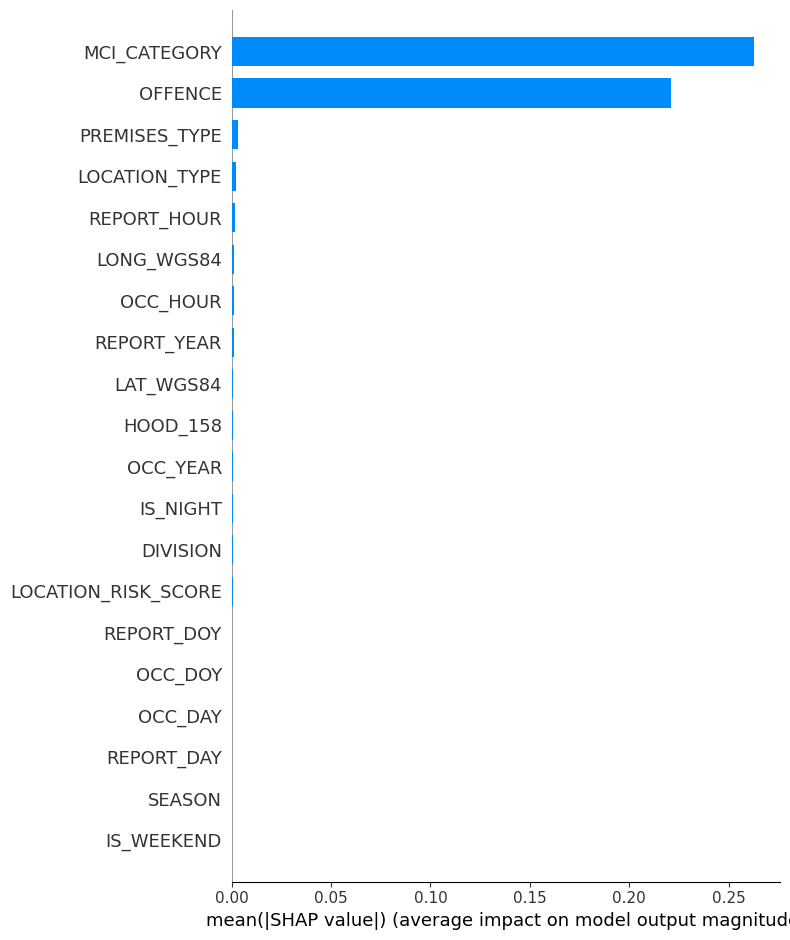

Predicted class for instance 0: 0


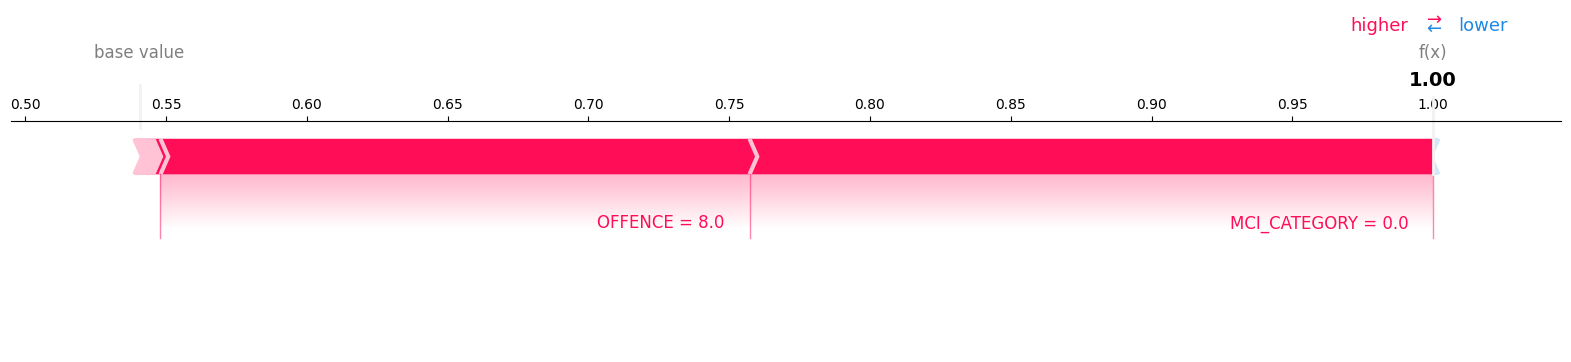

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

In [ ]:
import shap
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# Use a small subset of test data for explainability
subset_size = 100
X_sample = X_test[:subset_size].copy()
y_sample = y_test[:subset_size].copy()

# === SHAP (Unified Explainer API for Multiclass) ===

# Initialize SHAP explainer using the training data
explainer_shap = shap.Explainer(best_model, X_train)
shap_values = explainer_shap(X_sample)

# Check dimensions
print("shap_values.values.shape:", shap_values.values.shape)  # (100, 24, 5)
print("X_sample.shape:", X_sample.shape)

# SHAP Summary plot for a specific class (e.g., class 0)
shap.summary_plot(shap_values[..., 0], X_sample, plot_type="bar")  # Change index for other classes

# === SHAP Force Plot for a Single Instance ===
instance_idx = 0
pred_class = best_model.predict(X_sample.iloc[[instance_idx]])[0]
print(f"Predicted class for instance {instance_idx}: {pred_class}")

shap.initjs()
shap.force_plot(
    shap_values.base_values[instance_idx][pred_class],
    shap_values.values[instance_idx, :, pred_class],
    X_sample.iloc[instance_idx],
    matplotlib=True
)

# === LIME ===

# Clean data to avoid LIME's truncnorm issues
X_train_clean = X_train.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
X_sample_clean = X_sample[X_train_clean.columns]

# Drop constant columns (zero variance)
selector = VarianceThreshold(threshold=0.0)
selector.fit(X_train_clean)
X_train_var = X_train_clean.loc[:, selector.get_support()]
X_sample_var = X_sample_clean.loc[:, selector.get_support()]

# Identify dropped columns to fill them during prediction
dropped_columns = [col for col in X_train.columns if col not in X_train_var.columns]

# Custom LIME predict function that rebuilds the full input
def predict_fn_lime(x):
    df = pd.DataFrame(x, columns=X_train_var.columns)
    for col in dropped_columns:
        df[col] = 0  # Fill dropped columns with default value (mean or 0)
    df = df[X_train.columns]  # Ensure correct column order
    return best_model.predict_proba(df)

# Initialize LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_var),
    feature_names=X_train_var.columns.tolist(),
    class_names=np.unique(y).astype(str),
    mode='classification'
)

# Explain one instance
exp = explainer_lime.explain_instance(
    data_row=X_sample_var.iloc[instance_idx],
    predict_fn=predict_fn_lime,
    num_features=10
)

# Show LIME explanation
exp.show_in_notebook(show_table=True, show_all=False)


**Model Deployment Using FLASK**

In [ ]:
from pyngrok import conf

conf.get_default().auth_token = "2vW53k3Zgq1K2mQIiNabxrKlNgQ_2GrYC3DbDWG2S7cGWoZqS"


In [ ]:
from flask import Flask, request, jsonify
from pyngrok import ngrok
import joblib
import pandas as pd
import json
import threading

# Load model and features
model = joblib.load("random_forest_model.pkl")
with open("feature_names.json", "r") as f:
    feature_names = json.load(f)

# Flask app setup
app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    try:
        data = request.get_json()
        df = pd.DataFrame(data)
        df = df[feature_names]
        preds = model.predict(df)
        return jsonify({"predictions": preds.tolist()})
    except Exception as e:
        return jsonify({"error": str(e)})

def run_app():
    app.run(port=5001)

thread = threading.Thread(target=run_app)
thread.start()

# Connect via ngrok
public_url = ngrok.connect(5001)
print(f"🔗 Public URL: {public_url}")


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit


🔗 Public URL: NgrokTunnel: "https://3faa-35-237-117-243.ngrok-free.app" -> "http://localhost:5001"


In [ ]:
import requests

url = "https://3faa-35-237-117-243.ngrok-free.app/predict"

data = [
    {
        "REPORT_YEAR": 2024,
        "REPORT_MONTH": 5,
        "REPORT_DAY": 14,
        "REPORT_DOY": 134,
        "REPORT_DOW": 2,
        "REPORT_HOUR": 15,
        "OCC_YEAR": 2024,
        "OCC_MONTH": 5,
        "OCC_DAY": 13,
        "OCC_DOY": 133,
        "OCC_DOW": 1,
        "OCC_HOUR": 14,
        "DIVISION": "D12",
        "LOCATION_TYPE": "Street",
        "PREMISES_TYPE": "Apartment",
        "OFFENCE": "Assault",
        "MCI_CATEGORY": "Violent Crime",
        "HOOD_158": "123",
        "LONG_WGS84": -79.3832,
        "LAT_WGS84": 43.6532,
        "IS_WEEKEND": 0,
        "IS_NIGHT": 0,
        "SEASON": "Spring",
        "LOCATION_RISK_SCORE": 0.82
    }
]

response = requests.post(url, json=data)
print(response.json())


INFO:werkzeug:127.0.0.1 - - [10/Apr/2025 01:23:08] "POST /predict HTTP/1.1" 200 -


{'error': "could not convert string to float: 'D12'"}
